In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Basic Imports

In [8]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [9]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [10]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [11]:
from scipy.optimize import minimize

### Ansatz State

In [12]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [13]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [14]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [15]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [16]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [17]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [18]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [19]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [20]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [21]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [22]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [23]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="CG",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [24]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [25]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [26]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [27]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)

## Visualization

In [28]:
approximated_energies = []

In [29]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [30]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies[-NUM_ITERATIONS:])
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [31]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [32]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

27it [00:05,  5.06it/s]
27it [00:03,  7.95it/s]
27it [00:02,  9.32it/s]
27it [00:02, 10.12it/s]
27it [00:02, 10.21it/s]
27it [00:02, 10.60it/s]
27it [00:02,  9.97it/s]
27it [00:02, 10.25it/s]
27it [00:02,  9.62it/s]
27it [00:02,  9.34it/s]
27it [00:02, 10.50it/s]
27it [00:03,  8.95it/s]
27it [00:02,  9.37it/s]
27it [00:02,  9.53it/s]
27it [00:02, 11.00it/s]
27it [00:03,  8.76it/s]
27it [00:02,  9.72it/s]
27it [00:03,  8.79it/s]
27it [00:03,  8.85it/s]
27it [00:02,  9.18it/s]
27it [00:02,  9.15it/s]
27it [00:02,  9.56it/s]
27it [00:02, 10.91it/s]
27it [00:02, 11.44it/s]
27it [00:02, 10.85it/s]
27it [00:02, 11.08it/s]
27it [00:02, 11.75it/s]
27it [00:02, 11.66it/s]
27it [00:02,  9.90it/s]
27it [00:02, 10.52it/s]
27it [00:02, 12.44it/s]
27it [00:02, 11.48it/s]
27it [00:02, 12.89it/s]
27it [00:01, 14.48it/s]
27it [00:01, 13.83it/s]
27it [00:01, 13.81it/s]
27it [00:02, 13.10it/s]
27it [00:02, 12.75it/s]
27it [00:02, 12.03it/s]
27it [00:02,  9.08it/s]
27it [00:02,  9.86it/s]
27it [00:02,  9.

27it [00:05,  5.25it/s]
27it [00:04,  5.40it/s]
27it [00:05,  5.37it/s]
27it [00:05,  5.38it/s]
27it [00:04,  6.16it/s]
27it [00:04,  5.59it/s]
27it [00:04,  6.02it/s]
27it [00:04,  5.79it/s]
27it [00:04,  5.53it/s]
27it [00:05,  5.29it/s]
27it [00:04,  5.82it/s]
27it [00:04,  5.66it/s]
27it [00:04,  5.64it/s]
27it [00:04,  5.90it/s]
27it [00:04,  5.67it/s]
27it [00:04,  5.74it/s]
27it [00:04,  5.48it/s]
27it [00:04,  5.74it/s]
27it [00:04,  5.62it/s]
27it [00:05,  4.87it/s]
27it [00:05,  4.67it/s]
27it [00:05,  4.99it/s]
27it [00:04,  5.77it/s]
27it [00:05,  5.39it/s]
27it [00:04,  5.67it/s]
27it [00:04,  5.88it/s]
27it [00:04,  5.73it/s]
27it [00:04,  6.19it/s]
27it [00:04,  5.63it/s]
27it [00:04,  6.15it/s]
27it [00:04,  5.54it/s]
27it [00:04,  5.45it/s]
27it [00:05,  4.64it/s]
27it [00:05,  5.28it/s]
27it [00:04,  5.56it/s]
27it [00:05,  4.95it/s]
27it [00:04,  5.65it/s]
27it [00:05,  4.94it/s]
27it [00:06,  4.38it/s]
27it [00:05,  4.69it/s]
27it [00:05,  4.89it/s]
27it [00:04,  5.

         Current function value: -7.561478
         Iterations: 1
         Function evaluations: 540
         Gradient evaluations: 16
[5.20149098 0.18059289 3.6353865  1.26519005 1.16011937 3.13258603
 1.0949836  2.78474703 1.96961402 3.50512472 4.86350772 3.2036525
 5.39105862 5.8496057  2.85883281 0.96979561 3.83729526 0.76814933
 2.15434776 4.92685869 3.86142833 6.08996489 1.08141396 4.23076726
 5.97024572 0.87514168 5.68921785 2.78378328 2.0650124  5.38059826
 2.00218639 5.05029251]


27it [00:04,  5.75it/s]


CPU times: total: 25min 39s
Wall time: 38min 16s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.537931810956576

Approximation Error
0.04131383995647483


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


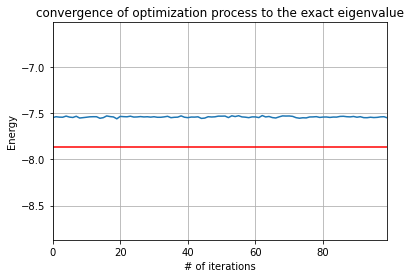

In [33]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [34]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

27it [00:04,  5.84it/s]
27it [00:04,  5.40it/s]
27it [00:05,  5.32it/s]
27it [00:04,  5.71it/s]
27it [00:04,  5.86it/s]
27it [00:04,  5.87it/s]
27it [00:04,  5.72it/s]
27it [00:04,  5.94it/s]
27it [00:04,  5.71it/s]
27it [00:04,  5.69it/s]
27it [00:04,  5.85it/s]
27it [00:04,  5.46it/s]
27it [00:04,  5.49it/s]
27it [00:04,  5.54it/s]
27it [00:05,  5.29it/s]
27it [00:04,  5.54it/s]
27it [00:04,  5.64it/s]
27it [00:04,  6.47it/s]
27it [00:04,  6.01it/s]
27it [00:04,  5.90it/s]
27it [00:04,  5.79it/s]
27it [00:04,  5.72it/s]
27it [00:04,  5.62it/s]
27it [00:04,  5.96it/s]
27it [00:05,  5.39it/s]
27it [00:04,  5.56it/s]
27it [00:05,  5.23it/s]
27it [00:04,  5.76it/s]
27it [00:04,  5.93it/s]
27it [00:04,  5.45it/s]
27it [00:04,  5.98it/s]
27it [00:04,  5.78it/s]
27it [00:04,  5.60it/s]
27it [00:04,  5.70it/s]
27it [00:04,  5.82it/s]
27it [00:04,  5.84it/s]
27it [00:04,  5.73it/s]
27it [00:04,  5.84it/s]
27it [00:04,  5.63it/s]
27it [00:05,  5.29it/s]
27it [00:05,  4.52it/s]
27it [00:05,  5.

27it [00:04,  6.05it/s]
27it [00:04,  6.06it/s]
27it [00:04,  6.29it/s]
27it [00:04,  6.40it/s]
27it [00:05,  5.28it/s]
27it [00:05,  5.29it/s]
27it [00:04,  5.88it/s]
27it [00:04,  6.12it/s]
27it [00:04,  5.57it/s]
27it [00:04,  6.05it/s]
27it [00:04,  5.65it/s]
27it [00:04,  5.67it/s]
27it [00:04,  5.88it/s]
27it [00:05,  5.25it/s]
27it [00:04,  5.90it/s]
27it [00:04,  5.94it/s]
27it [00:04,  5.86it/s]
27it [00:04,  6.30it/s]
27it [00:04,  5.70it/s]
27it [00:04,  5.54it/s]
27it [00:04,  5.59it/s]
27it [00:04,  5.73it/s]
27it [00:05,  5.34it/s]
27it [00:04,  5.56it/s]
27it [00:04,  5.69it/s]
27it [00:04,  5.69it/s]
27it [00:04,  5.61it/s]
27it [00:04,  5.94it/s]
27it [00:04,  5.80it/s]
27it [00:04,  6.05it/s]
27it [00:04,  6.26it/s]
27it [00:04,  6.55it/s]
27it [00:04,  6.28it/s]
27it [00:04,  5.96it/s]
27it [00:04,  6.38it/s]
27it [00:04,  5.69it/s]
27it [00:05,  5.37it/s]
27it [00:04,  6.49it/s]
27it [00:04,  5.49it/s]
27it [00:04,  5.99it/s]
27it [00:04,  5.80it/s]
27it [00:04,  6.

         Current function value: -7.426903
         Iterations: 1
         Function evaluations: 671
         Gradient evaluations: 20
[1.6318881  0.83648986 5.34514029 2.95820499 2.21501884 0.6731783
 2.29989617 2.2342452  2.25365551 1.31334758 3.53460984 0.17097347
 1.62747015 1.08400951 0.82394403 4.14161547 0.6066823  1.53765488
 1.32107429 2.34447272 1.51789564 1.90915267 5.89833139 5.18338568
 6.21933082 4.16890372 3.42042793 3.85290183 4.34029147 4.64298926
 1.12516543 0.23758288]


27it [00:05,  5.33it/s]

CPU times: total: 33min 35s
Wall time: 54min 53s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.418605194889294

Approximation Error
0.056489988828271685


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


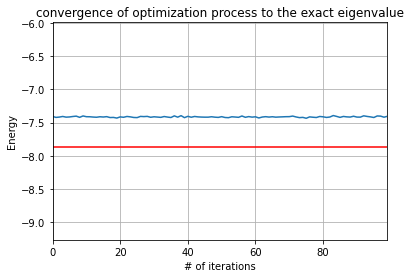

In [35]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [36]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [37]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

15it [00:02,  6.41it/s]
15it [00:02,  6.38it/s]
15it [00:02,  5.83it/s]
15it [00:02,  5.92it/s]
15it [00:02,  6.17it/s]
15it [00:02,  5.34it/s]
15it [00:02,  6.00it/s]
15it [00:02,  5.73it/s]
15it [00:02,  6.36it/s]
15it [00:02,  6.19it/s]
15it [00:02,  5.63it/s]
15it [00:02,  6.00it/s]
15it [00:02,  5.98it/s]
15it [00:02,  5.99it/s]
15it [00:02,  6.11it/s]
15it [00:02,  6.32it/s]
15it [00:02,  5.12it/s]
15it [00:02,  5.89it/s]
15it [00:02,  6.52it/s]
15it [00:02,  5.63it/s]
15it [00:02,  5.52it/s]
15it [00:02,  5.32it/s]
15it [00:02,  5.67it/s]
15it [00:02,  5.69it/s]
15it [00:02,  5.52it/s]
15it [00:02,  6.28it/s]
15it [00:02,  6.18it/s]
15it [00:02,  6.04it/s]
15it [00:02,  6.32it/s]
15it [00:02,  6.45it/s]
15it [00:02,  6.69it/s]
15it [00:02,  5.77it/s]
15it [00:02,  6.07it/s]
15it [00:02,  6.03it/s]
15it [00:02,  6.19it/s]
15it [00:02,  6.60it/s]
15it [00:02,  5.84it/s]
15it [00:02,  5.89it/s]
15it [00:02,  6.01it/s]
15it [00:02,  6.15it/s]
15it [00:02,  5.97it/s]
15it [00:02,  6.

15it [00:02,  6.91it/s]
15it [00:02,  6.84it/s]
15it [00:02,  6.37it/s]
15it [00:02,  6.87it/s]
15it [00:02,  6.88it/s]
15it [00:02,  6.33it/s]
15it [00:02,  6.46it/s]
15it [00:02,  6.92it/s]
15it [00:02,  6.78it/s]
15it [00:02,  6.84it/s]
15it [00:02,  7.18it/s]
15it [00:02,  6.48it/s]
15it [00:02,  6.76it/s]
15it [00:02,  7.36it/s]
15it [00:02,  6.89it/s]
15it [00:02,  6.80it/s]
15it [00:02,  6.89it/s]
15it [00:02,  7.16it/s]
15it [00:02,  6.55it/s]
15it [00:02,  6.79it/s]
15it [00:02,  6.42it/s]
15it [00:02,  7.03it/s]
15it [00:02,  7.22it/s]
15it [00:02,  6.77it/s]
15it [00:02,  6.64it/s]
15it [00:02,  6.44it/s]
15it [00:02,  6.78it/s]
15it [00:02,  6.68it/s]
15it [00:02,  5.79it/s]
15it [00:02,  6.70it/s]
15it [00:02,  7.25it/s]
15it [00:01,  7.63it/s]
15it [00:01,  7.69it/s]
15it [00:02,  6.98it/s]
15it [00:02,  6.67it/s]
15it [00:02,  7.20it/s]
15it [00:02,  7.02it/s]
15it [00:02,  6.93it/s]
15it [00:02,  6.15it/s]
15it [00:01,  7.54it/s]
15it [00:02,  6.62it/s]
15it [00:02,  6.

15it [00:02,  6.25it/s]
15it [00:02,  6.57it/s]
15it [00:02,  6.69it/s]
15it [00:02,  6.13it/s]
15it [00:02,  7.08it/s]
15it [00:02,  6.84it/s]
15it [00:02,  6.97it/s]
15it [00:02,  6.66it/s]
15it [00:02,  6.71it/s]
15it [00:01,  7.62it/s]
15it [00:02,  6.98it/s]
15it [00:02,  7.00it/s]
15it [00:02,  7.10it/s]
15it [00:02,  6.25it/s]
15it [00:02,  6.53it/s]
15it [00:01,  7.55it/s]
15it [00:02,  6.75it/s]
15it [00:02,  6.74it/s]
15it [00:02,  6.72it/s]
15it [00:02,  6.10it/s]
15it [00:02,  6.37it/s]
15it [00:02,  6.58it/s]
15it [00:02,  6.24it/s]
15it [00:02,  6.34it/s]
15it [00:02,  6.57it/s]
15it [00:02,  6.85it/s]
15it [00:02,  7.38it/s]
15it [00:02,  7.34it/s]
15it [00:02,  6.80it/s]
15it [00:02,  6.41it/s]
15it [00:02,  6.96it/s]
15it [00:02,  6.44it/s]
15it [00:02,  6.53it/s]
15it [00:01,  7.65it/s]
15it [00:02,  6.80it/s]
15it [00:02,  6.99it/s]
15it [00:02,  6.84it/s]
15it [00:02,  6.70it/s]
15it [00:02,  6.68it/s]
15it [00:02,  7.13it/s]
15it [00:02,  5.96it/s]
15it [00:02,  7.

         Current function value: -0.807995
         Iterations: 0
         Function evaluations: 870
         Gradient evaluations: 26
[5.5993913  5.59022749 5.72467075 2.85634742 2.13282259 3.77288334
 4.69283915 2.85620382 0.48859269 3.9467261  0.6463655  2.86777775
 1.1960895  1.34934151 3.71741072 3.46232589 3.66282522 0.10802313
 2.88848523 5.28543522 1.49866955 5.73392663 0.49017547 4.76702877
 3.31967157 3.62660844 2.76600809 3.66112447 1.01023477 3.35728754
 2.52804294 5.32677826]


15it [00:01,  7.98it/s]

CPU times: total: 23min 58s
Wall time: 32min 20s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.7810841640673141

Approximation Error
0.579446150211688


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


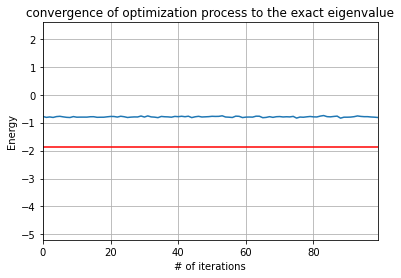

In [38]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [39]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

15it [00:02,  7.25it/s]
15it [00:02,  7.43it/s]
15it [00:02,  6.81it/s]
15it [00:02,  7.41it/s]
15it [00:01,  7.81it/s]
15it [00:01,  8.60it/s]
15it [00:02,  7.14it/s]
15it [00:02,  6.97it/s]
15it [00:02,  7.49it/s]
15it [00:02,  7.44it/s]
15it [00:01,  8.15it/s]
15it [00:02,  7.41it/s]
15it [00:01,  8.38it/s]
15it [00:01,  8.52it/s]
15it [00:01,  8.79it/s]
15it [00:01,  8.05it/s]
15it [00:01,  8.13it/s]
15it [00:01,  8.09it/s]
15it [00:02,  7.19it/s]
15it [00:02,  7.17it/s]
15it [00:01,  8.03it/s]
15it [00:02,  7.24it/s]
15it [00:02,  6.94it/s]
15it [00:02,  7.43it/s]
15it [00:02,  7.17it/s]
15it [00:02,  7.45it/s]
15it [00:02,  6.70it/s]
15it [00:02,  7.13it/s]
15it [00:02,  7.15it/s]
15it [00:02,  5.93it/s]
15it [00:02,  7.48it/s]
15it [00:01,  7.74it/s]
15it [00:01,  7.85it/s]
15it [00:01,  7.59it/s]
15it [00:02,  6.87it/s]
15it [00:01,  7.63it/s]
15it [00:02,  7.50it/s]
15it [00:02,  7.04it/s]
15it [00:01,  7.75it/s]
15it [00:01,  7.71it/s]
15it [00:02,  7.12it/s]
15it [00:01,  8.

15it [00:01,  7.97it/s]
15it [00:01,  8.47it/s]
15it [00:01,  7.53it/s]
15it [00:01,  8.04it/s]
15it [00:01,  7.74it/s]
15it [00:01,  8.02it/s]
15it [00:01,  7.72it/s]
15it [00:01,  8.02it/s]
15it [00:02,  7.11it/s]
15it [00:01,  7.75it/s]
15it [00:01,  7.83it/s]
15it [00:02,  7.30it/s]
15it [00:02,  7.23it/s]
15it [00:02,  7.00it/s]
15it [00:02,  6.85it/s]
15it [00:01,  7.76it/s]
15it [00:01,  7.69it/s]
15it [00:02,  7.04it/s]
15it [00:02,  6.64it/s]
15it [00:02,  6.74it/s]
15it [00:02,  7.34it/s]
15it [00:01,  7.87it/s]
15it [00:02,  7.30it/s]
15it [00:02,  6.85it/s]
15it [00:02,  6.96it/s]
15it [00:01,  7.67it/s]
15it [00:01,  7.65it/s]
15it [00:01,  8.85it/s]
15it [00:02,  7.42it/s]
15it [00:01,  7.91it/s]
15it [00:02,  7.40it/s]
15it [00:02,  7.10it/s]
15it [00:01,  7.52it/s]
15it [00:01,  7.65it/s]
15it [00:01,  8.13it/s]
15it [00:01,  8.58it/s]
15it [00:01,  7.57it/s]
15it [00:02,  7.12it/s]
15it [00:01,  8.12it/s]
15it [00:01,  8.69it/s]
15it [00:01,  8.68it/s]
15it [00:01,  7.

15it [00:01,  8.13it/s]
15it [00:01,  9.03it/s]
15it [00:01,  9.89it/s]
15it [00:01, 10.32it/s]
15it [00:01,  9.97it/s]
15it [00:01,  8.63it/s]
15it [00:01,  9.46it/s]
15it [00:02,  7.25it/s]
15it [00:01,  9.35it/s]
15it [00:01,  8.55it/s]
15it [00:01,  8.49it/s]
15it [00:01,  7.73it/s]
15it [00:01,  8.63it/s]
15it [00:01,  8.81it/s]
15it [00:01,  9.39it/s]
15it [00:01,  9.15it/s]
15it [00:01,  8.67it/s]
15it [00:01,  7.92it/s]
15it [00:01,  7.92it/s]
15it [00:01,  8.19it/s]
15it [00:01,  8.48it/s]
15it [00:01,  8.39it/s]
15it [00:01,  8.37it/s]


         Current function value: -0.959735
         Iterations: 1
         Function evaluations: 705
         Gradient evaluations: 21
[1.11177258 0.31675763 2.75231494 4.96954552 5.02782084 5.66879558
 5.87957387 0.01976963 6.16321181 3.27699693 0.02763685 4.46667316
 0.24495025 3.95707616 4.65368269 4.04089252 3.75875254 3.51297388
 5.85825342 0.50490004 1.85830786 5.87189504 0.21307943 1.33995694
 2.96842306 2.66348139 2.68335618 3.67470596 1.22286808 2.13972818
 1.59044378 2.55702603]


15it [00:01,  8.85it/s]

CPU times: total: 19min 55s
Wall time: 23min 2s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-0.942975523839342

Approximation Error
0.4922800831837006


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


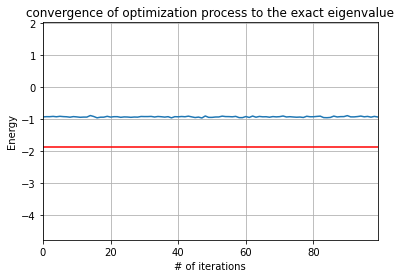

In [40]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [41]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [42]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

11it [00:01,  7.67it/s]
11it [00:01,  9.49it/s]
11it [00:01,  8.00it/s]
11it [00:01,  8.33it/s]
11it [00:01,  8.76it/s]
11it [00:01,  8.31it/s]
11it [00:01,  8.61it/s]
11it [00:01,  9.54it/s]
11it [00:01,  8.38it/s]
11it [00:01,  9.20it/s]
11it [00:01,  8.86it/s]
11it [00:01,  8.86it/s]
11it [00:01,  8.71it/s]
11it [00:01,  8.62it/s]
11it [00:01,  8.50it/s]
11it [00:01,  7.56it/s]
11it [00:01,  8.06it/s]
11it [00:01,  7.70it/s]
11it [00:01,  9.75it/s]
11it [00:01, 10.51it/s]
11it [00:01,  8.91it/s]
11it [00:01,  7.60it/s]
11it [00:01,  8.14it/s]
11it [00:01,  9.62it/s]
11it [00:01,  9.71it/s]
11it [00:01,  8.64it/s]
11it [00:01,  7.83it/s]
11it [00:01,  7.83it/s]
11it [00:01,  8.96it/s]
11it [00:01,  8.63it/s]
11it [00:01,  9.54it/s]
11it [00:01,  8.75it/s]
11it [00:01,  8.95it/s]
11it [00:01,  8.63it/s]
11it [00:01,  9.13it/s]
11it [00:01,  9.97it/s]
11it [00:01,  8.71it/s]
11it [00:01,  7.82it/s]
11it [00:01,  7.10it/s]
11it [00:01,  8.32it/s]
11it [00:01,  8.12it/s]
11it [00:01,  8.

11it [00:01,  9.04it/s]
11it [00:01,  9.00it/s]
11it [00:01,  8.54it/s]
11it [00:01,  9.25it/s]
11it [00:01,  8.91it/s]
11it [00:01, 10.35it/s]
11it [00:01, 10.66it/s]
11it [00:01, 10.20it/s]
11it [00:01,  9.59it/s]
11it [00:01,  9.01it/s]
11it [00:01,  8.53it/s]
11it [00:01,  9.27it/s]
11it [00:01,  9.91it/s]
11it [00:01,  9.02it/s]
11it [00:01,  8.89it/s]
11it [00:01,  9.39it/s]
11it [00:01,  8.65it/s]
11it [00:01,  9.47it/s]
11it [00:01,  9.33it/s]
11it [00:01,  8.91it/s]
11it [00:01,  8.06it/s]
11it [00:01,  8.97it/s]
11it [00:01,  9.13it/s]
11it [00:01,  8.40it/s]
11it [00:01,  7.71it/s]
11it [00:01,  9.14it/s]
11it [00:01,  8.59it/s]
11it [00:01,  8.17it/s]
11it [00:01,  8.94it/s]
11it [00:01,  8.50it/s]
11it [00:01,  8.80it/s]
11it [00:01,  8.69it/s]
11it [00:01,  8.64it/s]
11it [00:01,  7.66it/s]
11it [00:01,  8.54it/s]
11it [00:01,  8.64it/s]
11it [00:01,  9.31it/s]
11it [00:01,  8.47it/s]
11it [00:01,  7.18it/s]
11it [00:01,  8.04it/s]
11it [00:01,  9.19it/s]
11it [00:01,  9.

11it [00:01,  8.82it/s]
11it [00:01,  8.91it/s]
11it [00:01,  9.64it/s]
11it [00:01,  9.81it/s]
11it [00:01,  9.21it/s]
11it [00:01,  9.08it/s]
11it [00:01,  9.35it/s]
11it [00:01,  8.60it/s]
11it [00:01,  8.12it/s]
11it [00:01,  8.65it/s]
11it [00:01,  8.00it/s]
11it [00:01,  8.24it/s]
11it [00:01,  9.41it/s]
11it [00:01,  9.41it/s]
11it [00:01,  8.56it/s]
11it [00:01,  9.17it/s]
11it [00:01,  9.87it/s]
11it [00:01,  9.13it/s]
11it [00:01,  8.62it/s]
11it [00:01,  8.89it/s]
11it [00:01,  8.65it/s]
11it [00:01,  8.67it/s]
11it [00:01,  9.79it/s]
11it [00:01, 10.31it/s]
11it [00:01,  7.54it/s]
11it [00:01,  8.39it/s]
11it [00:01,  9.62it/s]
11it [00:01,  9.56it/s]
11it [00:01,  8.53it/s]
11it [00:01,  8.16it/s]
11it [00:01,  8.95it/s]
11it [00:01,  7.22it/s]
11it [00:01,  8.02it/s]
11it [00:01,  9.19it/s]
11it [00:01,  8.33it/s]
11it [00:01,  7.49it/s]
11it [00:01,  8.53it/s]
11it [00:01,  8.92it/s]
11it [00:01,  7.94it/s]
11it [00:01,  9.04it/s]
11it [00:01,  7.87it/s]
11it [00:01,  8.

         Current function value: -0.255481
         Iterations: 0
         Function evaluations: 870
         Gradient evaluations: 26
[1.07593946 5.75967813 2.13656265 5.74673332 0.97082623 5.39689586
 0.83020743 2.09848427 4.93528274 3.71902708 4.18496104 6.15504711
 3.87974793 0.44075578 4.25866897 0.29100491 5.39938048 4.66648676
 1.20375922 0.98139889 4.17274951 0.35759685 3.41672877 4.00707651
 1.38844873 4.40735156 4.33255632 4.60865589 0.02073246 2.08175982
 3.63320237 2.20992974]


11it [00:01,  8.42it/s]

CPU times: total: 16min 36s
Wall time: 17min 58s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-0.24002577799455413

Approximation Error
0.8799562345478138


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


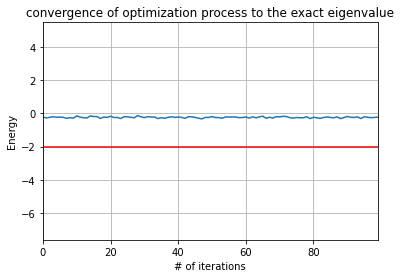

In [43]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [44]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

11it [00:01,  9.17it/s]
11it [00:01,  8.29it/s]
11it [00:01,  7.89it/s]
11it [00:01,  9.40it/s]
11it [00:01,  9.02it/s]
11it [00:01,  9.90it/s]
11it [00:01, 10.06it/s]
11it [00:01,  8.25it/s]
11it [00:01,  8.83it/s]
11it [00:01,  8.92it/s]
11it [00:01,  8.43it/s]
11it [00:01,  8.68it/s]
11it [00:01,  9.85it/s]
11it [00:01, 10.04it/s]
11it [00:01,  8.53it/s]
11it [00:01,  7.87it/s]
11it [00:01,  9.19it/s]
11it [00:01,  8.91it/s]
11it [00:01,  9.08it/s]
11it [00:01,  9.27it/s]
11it [00:01,  8.66it/s]
11it [00:01,  6.99it/s]
11it [00:01,  9.28it/s]
11it [00:01,  9.92it/s]
11it [00:01, 10.17it/s]
11it [00:01,  9.15it/s]
11it [00:01,  9.51it/s]
11it [00:01,  9.29it/s]
11it [00:01,  9.27it/s]
11it [00:01,  8.78it/s]
11it [00:01,  9.09it/s]
11it [00:01,  9.91it/s]
11it [00:01, 10.34it/s]
11it [00:01, 10.53it/s]
11it [00:01,  8.75it/s]
11it [00:01,  8.15it/s]
11it [00:01,  9.45it/s]
11it [00:01,  8.59it/s]
11it [00:01,  8.95it/s]
11it [00:01,  9.34it/s]
11it [00:01,  8.57it/s]
11it [00:01,  7.

11it [00:01,  9.58it/s]
11it [00:01,  8.57it/s]
11it [00:01,  8.97it/s]
11it [00:01,  8.66it/s]
11it [00:01,  8.23it/s]
11it [00:01,  8.47it/s]
11it [00:01,  9.30it/s]
11it [00:01,  9.67it/s]
11it [00:01,  8.31it/s]
11it [00:01,  8.76it/s]
11it [00:01,  8.92it/s]
11it [00:01,  9.00it/s]
11it [00:01,  8.46it/s]
11it [00:01,  8.47it/s]
11it [00:01,  9.49it/s]
11it [00:01,  9.18it/s]
11it [00:01,  9.67it/s]
11it [00:01,  9.57it/s]
11it [00:01,  8.80it/s]
11it [00:01,  9.63it/s]
11it [00:01,  9.14it/s]
11it [00:01, 10.51it/s]
11it [00:01, 10.40it/s]
11it [00:01,  9.51it/s]
11it [00:01,  9.44it/s]
11it [00:01,  9.39it/s]
11it [00:01,  9.09it/s]
11it [00:01,  8.65it/s]
11it [00:01,  8.10it/s]
11it [00:01,  8.58it/s]
11it [00:01,  8.80it/s]
11it [00:01,  8.66it/s]
11it [00:01,  8.64it/s]
11it [00:01,  8.42it/s]
11it [00:01,  8.28it/s]
11it [00:01,  7.99it/s]
11it [00:01,  9.27it/s]
11it [00:01,  8.96it/s]
11it [00:01,  9.36it/s]
11it [00:01,  7.74it/s]
11it [00:01,  9.03it/s]
11it [00:01,  9.

         Current function value: -0.283349
         Iterations: 1
         Function evaluations: 671
         Gradient evaluations: 20
[0.86182027 1.15121698 2.38066319 3.6254182  2.73818258 4.41098481
 3.00495467 4.60952882 1.80860914 2.36368924 2.88716178 4.87223769
 1.51746171 2.53837568 0.08559805 0.73841571 5.6425561  4.35022152
 5.7110862  1.78787176 3.32022517 1.13150242 1.99262952 5.66935828
 4.80864937 3.16275463 3.50635462 6.28010169 1.4748832  5.2577814
 1.70485388 1.50243001]


11it [00:01,  7.85it/s]

CPU times: total: 12min 55s
Wall time: 13min 58s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-0.2332214563853055

Approximation Error
0.8833592706472965


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


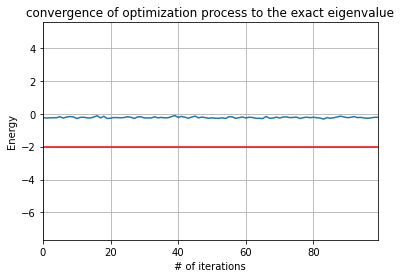

In [45]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [46]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [47]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [48]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

7it [00:00,  9.45it/s]
7it [00:00, 10.84it/s]
7it [00:00, 10.39it/s]
7it [00:00, 12.16it/s]
7it [00:00, 10.18it/s]
7it [00:00, 10.92it/s]
7it [00:00, 12.66it/s]
7it [00:00, 12.70it/s]
7it [00:00, 13.01it/s]
7it [00:00, 12.22it/s]
7it [00:00, 11.31it/s]
7it [00:00, 12.32it/s]
7it [00:00, 11.58it/s]
7it [00:00, 10.83it/s]
7it [00:00, 11.65it/s]
7it [00:00, 11.40it/s]
7it [00:00, 11.66it/s]
7it [00:00, 11.40it/s]
7it [00:00, 12.44it/s]
7it [00:00, 10.89it/s]
7it [00:00, 10.96it/s]
7it [00:00, 11.84it/s]
7it [00:00, 12.44it/s]
7it [00:00, 13.18it/s]
7it [00:00, 14.00it/s]
7it [00:00, 13.58it/s]
7it [00:00, 14.45it/s]
7it [00:00, 12.43it/s]
7it [00:00, 11.29it/s]
7it [00:00, 11.99it/s]
7it [00:00, 11.20it/s]
7it [00:00, 10.37it/s]
7it [00:00, 11.11it/s]
7it [00:00, 10.99it/s]
7it [00:00, 10.67it/s]
7it [00:00, 12.77it/s]
7it [00:00, 12.61it/s]
7it [00:00, 11.74it/s]
7it [00:00, 11.49it/s]
7it [00:00,  9.41it/s]
7it [00:00, 11.73it/s]
7it [00:00,  9.95it/s]
7it [00:00, 12.48it/s]
7it [00:00,

7it [00:00, 12.73it/s]
7it [00:00, 12.48it/s]
7it [00:00, 11.67it/s]
7it [00:00, 12.44it/s]
7it [00:00, 11.05it/s]
7it [00:00, 12.49it/s]
7it [00:00, 12.05it/s]
7it [00:00, 13.17it/s]
7it [00:00,  9.74it/s]
7it [00:00, 13.23it/s]
7it [00:00, 13.37it/s]
7it [00:00, 13.28it/s]
7it [00:00, 14.21it/s]
7it [00:00, 12.75it/s]
7it [00:00, 12.18it/s]
7it [00:00, 11.65it/s]
7it [00:00, 12.43it/s]
7it [00:00, 12.79it/s]
7it [00:00, 12.55it/s]
7it [00:00, 10.18it/s]
7it [00:00, 11.53it/s]
7it [00:00, 11.45it/s]
7it [00:00, 11.49it/s]
7it [00:00, 12.44it/s]
7it [00:00, 12.39it/s]
7it [00:00,  9.82it/s]
7it [00:00, 12.02it/s]
7it [00:00, 11.46it/s]
7it [00:00, 11.51it/s]
7it [00:00, 10.13it/s]
7it [00:00, 10.25it/s]
7it [00:00, 12.04it/s]
7it [00:00, 10.37it/s]
7it [00:00, 13.99it/s]
7it [00:00, 11.85it/s]
7it [00:00, 11.37it/s]
7it [00:00, 11.61it/s]
7it [00:00, 11.23it/s]
7it [00:00, 12.90it/s]
7it [00:00, 11.59it/s]
7it [00:00, 12.77it/s]
7it [00:00,  9.35it/s]
7it [00:00, 12.04it/s]
7it [00:00,

         Current function value: -0.166092
         Iterations: 0
         Function evaluations: 662
         Gradient evaluations: 26
[4.77742406 5.37936733 5.13717708 5.27512398 4.22743202 4.90920558
 5.02108057 1.89857299 3.79729748 4.4269807  1.98784233 5.3144217
 2.79284816 1.32825822 6.12749238 0.40575005 5.4202901  3.69634232
 5.94388377 0.69581571 6.03068487 0.45261291 3.25938841 1.59426587]


7it [00:00, 10.44it/s]

CPU times: total: 6min 12s
Wall time: 6min 42s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.20508022692578223

Approximation Error
0.8189473126429345


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


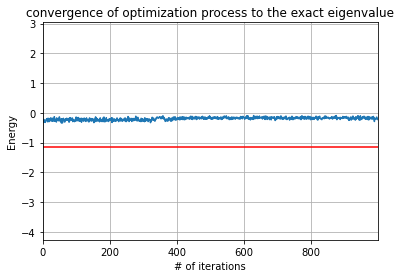

In [49]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [50]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

7it [00:00, 10.49it/s]
7it [00:00, 10.26it/s]
7it [00:00, 12.10it/s]
7it [00:00, 12.03it/s]
7it [00:00, 11.52it/s]
7it [00:00, 13.02it/s]
7it [00:00, 12.99it/s]
7it [00:00, 12.28it/s]
7it [00:00, 11.22it/s]
7it [00:00, 10.16it/s]
7it [00:00,  8.32it/s]
7it [00:00, 10.79it/s]
7it [00:00, 11.12it/s]
7it [00:00, 12.06it/s]
7it [00:00, 14.00it/s]
7it [00:00, 13.98it/s]
7it [00:00, 12.86it/s]
7it [00:00, 10.17it/s]
7it [00:00,  9.27it/s]
7it [00:00, 10.63it/s]
7it [00:00, 11.93it/s]
7it [00:00, 11.04it/s]
7it [00:00, 10.95it/s]
7it [00:00, 10.74it/s]
7it [00:00, 10.30it/s]
7it [00:00,  9.54it/s]
7it [00:00, 12.80it/s]
7it [00:00, 12.37it/s]
7it [00:00, 12.18it/s]
7it [00:00, 11.71it/s]
7it [00:00, 11.40it/s]
7it [00:00,  9.82it/s]
7it [00:00, 10.63it/s]
7it [00:00, 11.04it/s]
7it [00:00, 12.33it/s]
7it [00:00, 10.78it/s]
7it [00:00, 10.62it/s]
7it [00:00, 12.46it/s]
7it [00:00, 13.06it/s]
7it [00:00, 12.80it/s]
7it [00:00, 11.22it/s]
7it [00:00, 11.90it/s]
7it [00:00, 11.86it/s]
7it [00:00,

7it [00:00, 12.25it/s]
7it [00:00, 12.10it/s]
7it [00:00, 12.88it/s]
7it [00:00, 12.66it/s]
7it [00:00, 12.17it/s]
7it [00:00, 11.20it/s]
7it [00:00, 10.76it/s]
7it [00:00, 10.77it/s]
7it [00:00, 11.23it/s]
7it [00:00,  9.74it/s]
7it [00:00, 12.11it/s]
7it [00:00, 11.90it/s]
7it [00:00, 11.09it/s]
7it [00:00, 11.67it/s]
7it [00:00,  9.82it/s]
7it [00:00, 10.90it/s]
7it [00:00, 11.69it/s]
7it [00:00, 10.68it/s]
7it [00:00, 11.58it/s]
7it [00:00, 11.82it/s]
7it [00:00, 10.18it/s]
7it [00:00, 12.69it/s]
7it [00:00, 13.47it/s]
7it [00:00, 14.45it/s]
7it [00:00, 12.88it/s]
7it [00:00, 10.83it/s]
7it [00:00, 12.30it/s]
7it [00:00, 11.22it/s]
7it [00:00, 11.91it/s]
7it [00:00, 11.37it/s]
7it [00:00, 12.92it/s]
7it [00:00, 12.19it/s]
7it [00:00, 10.72it/s]
7it [00:00, 11.46it/s]
7it [00:00, 11.01it/s]
7it [00:00, 12.81it/s]
7it [00:00, 12.18it/s]
7it [00:00, 11.93it/s]
7it [00:00, 11.38it/s]
7it [00:00, 11.16it/s]
7it [00:00, 11.81it/s]
7it [00:00, 12.82it/s]
7it [00:00, 13.13it/s]
7it [00:00,

         Current function value: -0.308567
         Iterations: 1
         Function evaluations: 636
         Gradient evaluations: 25
[4.78741348 4.456423   3.94567471 5.15005742 3.86653199 1.55092621
 4.64887973 2.86465047 2.72512417 5.60997158 4.58716422 6.15844191
 1.38164634 6.25636547 0.07323931 6.21681518 5.87987131 2.78093168
 0.68207634 4.86893744 2.90290904 1.97008451 5.95558517 2.64727647]


7it [00:00, 10.52it/s]

CPU times: total: 6min 4s
Wall time: 6min 32s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.2650607870787065

Approximation Error
0.7659941744118212


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


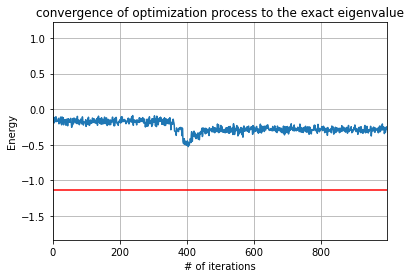

In [51]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [52]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 1000

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [53]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [54]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00, 15.35it/s]
3it [00:00, 17.14it/s]
3it [00:00, 15.37it/s]
3it [00:00,  9.96it/s]
3it [00:00, 17.65it/s]
3it [00:00, 17.29it/s]
3it [00:00, 13.56it/s]
3it [00:00, 17.45it/s]
3it [00:00, 14.35it/s]
3it [00:00, 13.71it/s]
3it [00:00, 14.95it/s]
3it [00:00, 18.02it/s]
3it [00:00, 14.69it/s]
3it [00:00, 17.60it/s]
3it [00:00, 19.80it/s]
3it [00:00, 12.37it/s]
3it [00:00, 15.22it/s]
3it [00:00, 19.14it/s]
3it [00:00, 19.20it/s]
3it [00:00, 14.11it/s]
3it [00:00, 17.44it/s]
3it [00:00, 15.42it/s]
3it [00:00, 13.75it/s]
3it [00:00, 17.46it/s]
3it [00:00, 19.20it/s]
3it [00:00, 17.45it/s]
3it [00:00, 17.41it/s]
3it [00:00, 17.46it/s]
3it [00:00, 16.00it/s]
3it [00:00, 16.00it/s]
3it [00:00, 17.45it/s]
3it [00:00, 16.00it/s]
3it [00:00, 18.41it/s]
3it [00:00, 16.88it/s]
3it [00:00, 15.60it/s]
3it [00:00, 16.95it/s]
3it [00:00, 19.35it/s]
3it [00:00, 16.57it/s]
3it [00:00, 14.71it/s]
3it [00:00, 17.65it/s]
3it [00:00, 18.18it/s]
3it [00:00, 14.96it/s]
3it [00:00, 16.57it/s]
3it [00:00,

3it [00:00, 13.26it/s]
3it [00:00, 17.43it/s]
3it [00:00, 21.33it/s]
3it [00:00, 13.69it/s]
3it [00:00, 12.23it/s]
3it [00:00, 16.90it/s]
3it [00:00, 16.53it/s]
3it [00:00, 17.80it/s]
3it [00:00, 20.41it/s]
3it [00:00, 18.24it/s]
3it [00:00, 18.07it/s]
3it [00:00, 17.24it/s]
3it [00:00, 16.95it/s]
3it [00:00, 16.62it/s]
3it [00:00, 18.24it/s]
3it [00:00, 18.93it/s]
3it [00:00, 17.00it/s]
3it [00:00, 18.07it/s]
3it [00:00, 21.66it/s]
3it [00:00, 18.87it/s]
3it [00:00, 18.24it/s]
3it [00:00, 19.54it/s]
3it [00:00, 16.76it/s]
3it [00:00, 15.26it/s]
3it [00:00, 18.69it/s]
3it [00:00, 18.58it/s]
3it [00:00, 13.51it/s]
3it [00:00, 17.27it/s]
3it [00:00, 17.45it/s]
3it [00:00, 17.45it/s]
3it [00:00, 14.77it/s]
3it [00:00, 19.14it/s]
3it [00:00, 13.02it/s]
3it [00:00, 17.45it/s]
3it [00:00,  8.89it/s]
3it [00:00, 14.64it/s]
3it [00:00, 15.71it/s]
3it [00:00, 14.29it/s]
3it [00:00, 13.19it/s]
3it [00:00, 18.69it/s]
3it [00:00, 18.07it/s]
3it [00:00, 15.27it/s]
3it [00:00, 16.26it/s]
3it [00:00,

         Current function value: -0.246746
         Iterations: 0
         Function evaluations: 420
         Gradient evaluations: 24
[1.45902274 4.2800846  4.54746175 1.4066196  0.75938522 5.63065052
 5.44577173 3.24038135 5.02721523 2.86637332 5.04280634 1.87564146
 5.17543112 2.02068153 3.94306278 2.90906639]


3it [00:00, 13.25it/s]

CPU times: total: 1min 15s
Wall time: 1min 20s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.18565791215756067

Approximation Error
0.8192185779115091


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


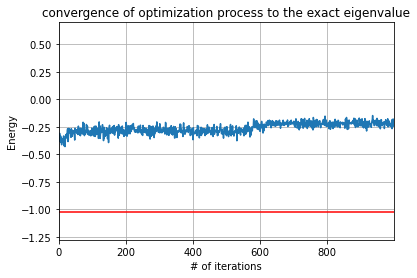

In [55]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [56]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 12.61it/s]
3it [00:00, 15.96it/s]
3it [00:00, 15.11it/s]
3it [00:00, 14.29it/s]
3it [00:00, 17.91it/s]
3it [00:00, 15.79it/s]
3it [00:00, 11.63it/s]
3it [00:00, 16.20it/s]
3it [00:00, 18.96it/s]
3it [00:00, 14.89it/s]
3it [00:00, 13.88it/s]
3it [00:00, 17.44it/s]
3it [00:00, 15.11it/s]
3it [00:00, 13.09it/s]
3it [00:00, 17.96it/s]
3it [00:00, 18.07it/s]
3it [00:00, 14.87it/s]
3it [00:00, 17.39it/s]
3it [00:00, 14.28it/s]
3it [00:00, 12.00it/s]
3it [00:00, 17.96it/s]
3it [00:00, 18.41it/s]
3it [00:00, 15.67it/s]
3it [00:00, 13.67it/s]
3it [00:00, 11.79it/s]
3it [00:00, 16.62it/s]
3it [00:00, 17.96it/s]
3it [00:00, 12.71it/s]
3it [00:00, 17.49it/s]
3it [00:00, 18.75it/s]
3it [00:00, 17.05it/s]
3it [00:00, 17.75it/s]
3it [00:00, 18.63it/s]
3it [00:00, 15.19it/s]
3it [00:00, 15.08it/s]
3it [00:00, 17.44it/s]
3it [00:00, 11.81it/s]
3it [00:00, 17.60it/s]
3it [00:00, 15.46it/s]
3it [00:00, 15.42it/s]
3it [00:00, 19.93it/s]
3it [00:00, 19.17it/s]
3it [00:00, 15.31it/s]
3it [00:00,

3it [00:00, 14.29it/s]
3it [00:00, 18.18it/s]
3it [00:00, 18.02it/s]
3it [00:00, 13.95it/s]
3it [00:00, 14.35it/s]
3it [00:00, 17.75it/s]
3it [00:00, 18.40it/s]
3it [00:00, 14.00it/s]
3it [00:00, 17.65it/s]
3it [00:00, 18.02it/s]
3it [00:00, 12.13it/s]
3it [00:00, 16.71it/s]


         Current function value: 0.039731
         Iterations: 2
         Function evaluations: 368
         Gradient evaluations: 21
[0.3686626  5.37948693 3.40249767 2.88135656 0.1862759  0.60850111
 2.21353204 3.6541939  0.87714782 1.70397256 0.67109549 3.3383139
 2.40455558 3.75472476 0.60461854 1.26665355]


3it [00:00, 16.81it/s]

CPU times: total: 1min 6s
Wall time: 1min 10s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
0.09683984605642193

Approximation Error
0.9057037490001875


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


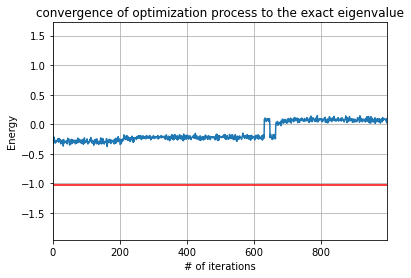

In [57]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [58]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [59]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00, 17.04it/s]
4it [00:00, 13.79it/s]
4it [00:00, 17.39it/s]
4it [00:00, 15.18it/s]
4it [00:00, 16.23it/s]
4it [00:00, 16.60it/s]
4it [00:00, 17.20it/s]
4it [00:00, 17.51it/s]
4it [00:00, 18.48it/s]
4it [00:00, 16.91it/s]
4it [00:00, 16.46it/s]
4it [00:00, 19.09it/s]
4it [00:00, 20.62it/s]
4it [00:00, 19.80it/s]
4it [00:00, 20.89it/s]
4it [00:00, 18.56it/s]
4it [00:00, 20.89it/s]
4it [00:00, 18.02it/s]
4it [00:00, 19.00it/s]
4it [00:00, 17.86it/s]
4it [00:00, 17.47it/s]
4it [00:00, 16.23it/s]
4it [00:00, 18.22it/s]
4it [00:00, 11.68it/s]
4it [00:00, 11.00it/s]
4it [00:00, 13.70it/s]
4it [00:00, 15.86it/s]
4it [00:00, 13.05it/s]
4it [00:00, 14.59it/s]
4it [00:00, 21.45it/s]
4it [00:00, 15.62it/s]
4it [00:00, 17.07it/s]
4it [00:00, 15.08it/s]
4it [00:00, 15.96it/s]
4it [00:00, 16.53it/s]
4it [00:00, 16.84it/s]
4it [00:00, 18.29it/s]
4it [00:00, 19.69it/s]
4it [00:00, 17.07it/s]
4it [00:00, 15.32it/s]
4it [00:00, 19.41it/s]
4it [00:00, 18.92it/s]
4it [00:00, 16.68it/s]
4it [00:00,

4it [00:00, 15.75it/s]
4it [00:00, 15.97it/s]
4it [00:00, 18.12it/s]
4it [00:00, 14.33it/s]
4it [00:00, 19.46it/s]
4it [00:00, 13.63it/s]
4it [00:00, 19.09it/s]
4it [00:00, 15.36it/s]
4it [00:00, 16.77it/s]
4it [00:00, 17.62it/s]
4it [00:00, 18.43it/s]
4it [00:00, 18.31it/s]
4it [00:00, 18.22it/s]
4it [00:00, 19.46it/s]
4it [00:00, 18.74it/s]
4it [00:00, 18.06it/s]
4it [00:00, 17.82it/s]
4it [00:00, 19.70it/s]
4it [00:00, 20.36it/s]
4it [00:00, 18.35it/s]
4it [00:00, 17.09it/s]
4it [00:00, 20.20it/s]
4it [00:00, 18.96it/s]
4it [00:00, 12.43it/s]
4it [00:00, 17.24it/s]
4it [00:00, 15.41it/s]
4it [00:00, 18.39it/s]
4it [00:00, 14.03it/s]
4it [00:00, 14.89it/s]
4it [00:00,  9.86it/s]
4it [00:00, 13.08it/s]
4it [00:00, 16.88it/s]
4it [00:00, 12.13it/s]
4it [00:00, 18.02it/s]
4it [00:00, 14.26it/s]
4it [00:00, 14.73it/s]
4it [00:00, 18.10it/s]
4it [00:00, 16.64it/s]
4it [00:00, 12.89it/s]
4it [00:00, 15.47it/s]
4it [00:00, 17.25it/s]
4it [00:00, 21.51it/s]
4it [00:00, 18.28it/s]
4it [00:00,

         Current function value: -0.380531
         Iterations: 0
         Function evaluations: 403
         Gradient evaluations: 23
[5.84370136 5.3822736  2.38946067 3.32297539 2.06106986 0.82357682
 1.47508963 5.26291364 0.90952356 1.84094043 2.37682473 2.37186888
 1.34502064 3.47406022 1.13121472 5.53858803]


4it [00:00, 16.00it/s]

CPU times: total: 1min 35s
Wall time: 1min 42s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.36729639344486287

Approximation Error
0.6345697509922265


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


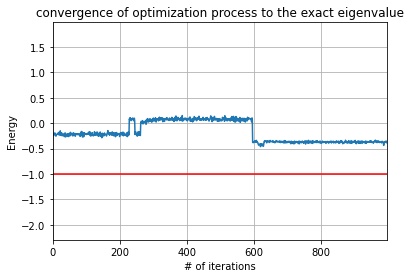

In [60]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [61]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

4it [00:00, 19.69it/s]
4it [00:00, 17.07it/s]
4it [00:00, 18.64it/s]
4it [00:00, 20.26it/s]
4it [00:00, 17.44it/s]
4it [00:00, 19.09it/s]
4it [00:00, 14.12it/s]
4it [00:00, 17.66it/s]
4it [00:00, 15.36it/s]
4it [00:00, 16.95it/s]
4it [00:00, 11.10it/s]
4it [00:00, 13.79it/s]
4it [00:00, 18.29it/s]
4it [00:00, 12.91it/s]
4it [00:00, 14.60it/s]
4it [00:00, 15.44it/s]
4it [00:00, 16.03it/s]
4it [00:00, 20.51it/s]
4it [00:00, 18.91it/s]
4it [00:00, 15.97it/s]
4it [00:00, 18.27it/s]
4it [00:00, 17.39it/s]
4it [00:00, 16.81it/s]
4it [00:00, 17.74it/s]
4it [00:00, 18.43it/s]
4it [00:00, 19.90it/s]
4it [00:00, 18.14it/s]
4it [00:00, 18.56it/s]
4it [00:00, 19.09it/s]
4it [00:00, 17.66it/s]
4it [00:00, 17.74it/s]
4it [00:00, 18.74it/s]
4it [00:00, 15.10it/s]
4it [00:00, 17.70it/s]
4it [00:00, 16.39it/s]
4it [00:00, 16.62it/s]
4it [00:00, 19.69it/s]
4it [00:00, 15.03it/s]
4it [00:00, 19.23it/s]
4it [00:00, 13.59it/s]
4it [00:00, 14.76it/s]
4it [00:00, 16.53it/s]
4it [00:00, 16.15it/s]
4it [00:00,

         Current function value: -0.327545
         Iterations: 1
         Function evaluations: 333
         Gradient evaluations: 19
[4.72613055 2.84397275 1.29754205 6.22621204 0.49134976 5.69962333
 4.96911923 0.93565628 1.4229115  1.35269113 4.82600874 4.20419074
 2.38504947 5.07353645 1.0687903  2.17387482]


4it [00:00, 17.78it/s]

CPU times: total: 1min 18s
Wall time: 1min 23s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.3263612917882798

Approximation Error
0.6752968712648333


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


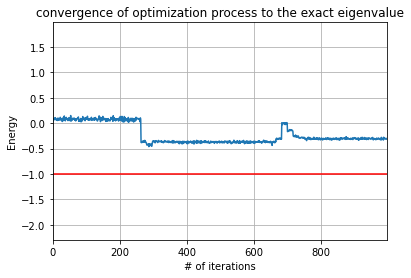

In [62]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)